In [1080]:
%load_ext autoreload
%autoreload 2

In [1082]:
import pandas as pd
import numpy as np
import glob
import random
from matplotlib import pyplot as plt
import itertools
import sys

In [1083]:
sys.path.insert(0, '..')
from src.run_detection import detect_active_areas as detect_active_areas_final

# Load data

In [5]:
param_df = pd.read_csv('../refit_thresholds.csv')
param_df = param_df[~param_df.min_power_threshold.isna()]
param_df.sample(4)

,house,machine,min_power_threshold,summed_power_min,summed_power_max,typical_duration,comment
26,9,tumble_dryer,500.0,5000.0,30000.0,1.8,NaN
8,3,tumble_dryer,500.0,6000.0,28000.0,1.2,NaN
1,1,washing_machine,500.0,2000.0,6000.0,0.7,NaN
13,5,washing_machine,500.0,2000.0,8000.0,1.0,problematic noise floor


In [1303]:
params = random.choice(param_df.to_dict('records'))
params

{'house': 3,
 'machine': 'tumble_dryer',
 'min_power_threshold': 500.0,
 'summed_power_min': 6000.0,
 'summed_power_max': 28000.0,
 'typical_duration': 1.2,
 'comment': nan}

In [1304]:
machine_series = pd.read_hdf(f'../data/refit/house_{params["house"]}_300s.hdf')[f'X_{params["machine"]}_power']
machine_series.describe()

count    157172.000000
mean         55.141896
std         308.177335
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        2579.071429
Name: X_tumble_dryer_power, dtype: float64

# Experiment

In [1305]:
temp = list(machine_series.groupby(machine_series.index.date))
while True:
    _, day_series = random.choice(temp)
    if day_series.max() >= params['min_power_threshold']:
        break
day_series.describe()

count     288.000000
mean      131.183373
std       475.161350
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      2336.520000
Name: X_tumble_dryer_power, dtype: float64

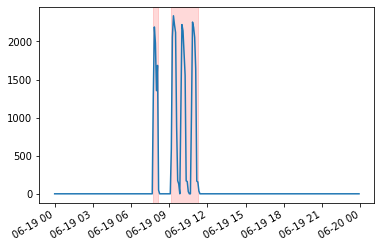

In [1306]:
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return itertools.zip_longest(*args, fillvalue=fillvalue)

def narrow_active_area(active_mask, active_area):
    start, end = active_area
    active_mask = active_mask[start:end]
    return active_mask[active_mask == True].index[0], active_mask[active_mask == True].index[-1]

def detect_active_areas(input_series, window_size = 12, greater_than=0, narrow=True):
    active_mask = input_series > greater_than
    temp = active_mask.rolling(window_size, center=True).sum()
    temp = (temp > 0) & (np.isfinite(input_series))
    temp = temp.astype('int8').diff()
    areas = grouper(temp.index[(temp == 1) | (temp == -1)], n=2)
    areas = [
        (start, end)
        for start, end in areas
        if active_mask[start:end].any()
    ]
    if not narrow:
        return list(areas)
    areas = (narrow_active_area(active_mask, a) for a in areas)
    areas = ((a, b) for a, b in areas if a != b)
    return list(areas)

def plot_active_areas(day_series, active_areas, ax=None):
    day_series.plot(ax=ax)
    for start, end in active_areas:
        ax.axvspan(start, end, alpha=0.15, color='red')
        
active_areas = detect_active_areas(
    day_series,
    window_size=int(params['typical_duration'] * 12 // 2),
    greater_than=params['min_power_threshold'] / 10,
)
plot_active_areas(day_series, active_areas, ax=plt.gca())

In [1307]:
all_active_areas = []
for _, day_series in list(machine_series.groupby(machine_series.index.date)):
    if day_series.max() < params['min_power_threshold']:
        continue
    active_areas = detect_active_areas(
        day_series,
        window_size=int(params['typical_duration'] * 12 // 2),
        greater_than=params['min_power_threshold'] / 10,
    )
    for a in active_areas:
        all_active_areas.append(a)

def calc_active_area_stats(machine_series, active_areas):
    active_area_stats = []
    for start, end in active_areas:
        active_area_series = machine_series[start:end]
        active_area_stats.append({
            'summed_power': active_area_series.sum(),
            'duration_hours': (end - start) / np.timedelta64(1, 'h'),
        })
    return pd.DataFrame(active_area_stats)

active_area_stats = calc_active_area_stats(machine_series, all_active_areas)
active_area_stats.describe()

,summed_power,duration_hours
count,637.000000,637.000000
mean,13567.920645,0.844322
std,9792.176617,0.619842
min,181.115563,0.083333
25%,8017.994186,0.500000
50%,12228.863690,0.750000
75%,16818.751398,0.916667
max,127831.506820,5.333333


0.9419152276295133


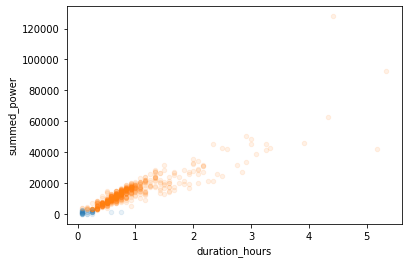

In [1308]:
good_mask = (
    (active_area_stats.summed_power >= params['summed_power_min'] / 2)
    # (active_area_stats.summed_power <= params['summed_power_max']) &
    # (active_area_stats.duration_hours >= params['typical_duration'] * 0.1)
    # (active_area_stats.duration_hours <= params['typical_duration'] * 3)
)
print(good_mask.mean())

fig, ax = plt.subplots()
active_area_stats[~good_mask].plot.scatter('duration_hours', 'summed_power', alpha=0.1, ax=ax)
active_area_stats[good_mask].plot.scatter('duration_hours', 'summed_power', alpha=0.1, c='C1', ax=ax);

In [1309]:
active_area_stats[~good_mask].summed_power.sum() / active_area_stats.summed_power.sum()

0.006484708138555357

/home/philippe/src/git.ihomelab.ch/SccerPhase2/load-shifting-potential/.venv/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1102: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


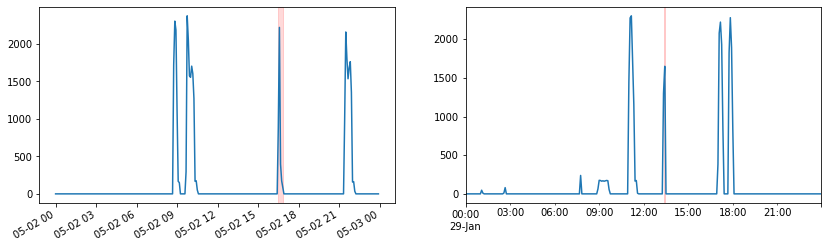

In [1310]:
def plot_day_with_active_area(machine_series, active_area, ax=None):
    start, end = active_area
    day_series = machine_series[str(start.date())]
    plot_active_areas(day_series, [active_area], ax=ax)
    
i_good, i_bad = [
    active_area_stats[m].sample().index.values.item()
    for m in [good_mask, ~good_mask]
]

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
for i_ax, i_active in enumerate([i_good, i_bad]):
    plot_day_with_active_area(machine_series, all_active_areas[i_active], ax=ax[i_ax])

0.6907378335949764
[([(0, 38)], 0.32725601777003976), ([(0, 19), (19, 38)], 0.02117442569107359), ([(0, 12), (12, 25), (25, 38)], 0.013557007703423496), ([(0, 9), (9, 19), (19, 28), (28, 38)], 0.15693463882641415), ([(0, 7), (7, 15), (15, 22), (22, 30), (30, 38)], 0.015444638322306909), ([(0, 6), (6, 12), (12, 19), (19, 25), (25, 31), (31, 38)], inf)]


/home/philippe/src/git.ihomelab.ch/SccerPhase2/load-shifting-potential/.venv/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1102: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


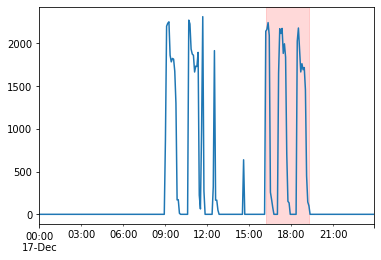

In [1317]:
def force_split_active_area(active_area_series, n):
    ind = active_area_series.index
    borders = np.linspace(0, len(ind), n + 1).astype(np.int32)
    borders[-1] = len(ind)
    if len(set(borders)) != n + 1:
        return None
    return list(zip(borders, borders[1:]))

def rate_active_area_split(active_area_series, split, params):
    split_series = [active_area_series.iloc[start:end] for start, end in split]
    
    if any(s.max() < params['min_power_threshold'] for s in split_series):
        return np.inf
    
    summed_power_values = np.array([s.sum() for s in split_series])
    
    undershoot = (params['summed_power_min'] - summed_power_values).clip(min=0).sum()
    overshoot = (summed_power_values - params['summed_power_max']).clip(min=0).sum()
    
    power_limit_loss = (overshoot + undershoot) / (params['summed_power_min'] + params['summed_power_max'])
    
    balance_loss = summed_power_values.std() / summed_power_values.mean() if len(split) > 1 else 0
    
    return power_limit_loss + 0.1 * balance_loss

def get_rated_active_area_splits(active_area_series, params):
    active_area_series = active_area_series.asfreq('5T')
    rated_splits = []
    max_n = min(10, int(active_area_series.sum() / params['summed_power_min']) + 1)
    for n in range(1, max_n):
        split = force_split_active_area(active_area_series, n)
        if split is None:
            continue
        rating = rate_active_area_split(active_area_series, split, params)
        rated_splits.append((split, rating))
    return rated_splits

temp = active_area_stats.summed_power >= params['summed_power_min'] * 1.5
print(temp.mean())
i_active = active_area_stats[temp].sample().index.values.item()
active_area = all_active_areas[i_active]
active_area_series = machine_series[active_area[0]:active_area[1]]
print(get_rated_active_area_splits(active_area_series, params))
plot_day_with_active_area(machine_series, all_active_areas[i_active], ax=plt.gca())

In [1261]:
final_active_areas = detect_active_areas_final(machine_series, params)
active_area_stats = calc_active_area_stats(machine_series, final_active_areas)
active_area_stats.describe()

,summed_power,duration_hours
count,230.000000,230.000000
mean,8767.779403,1.235507
std,2807.320352,0.323970
min,4176.573660,0.333333
25%,6469.377825,1.083333
50%,8348.725763,1.166667
75%,10683.424874,1.250000
max,17295.093040,2.750000


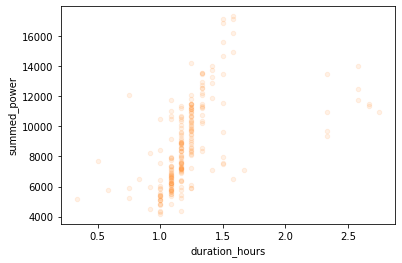

In [1262]:
active_area_stats.plot.scatter('duration_hours', 'summed_power', alpha=0.1, c='C1');

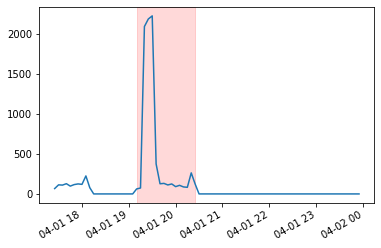

In [1271]:
plot_day_with_active_area(machine_series, random.choice(final_active_areas), ax=plt.gca())

In [1273]:
sum(machine_series[start:end].sum() for start, end in final_active_areas) / machine_series.sum()

0.9663126282124322